# Figure 6: Roary, Panaroo, PPanGGOLiN CLARC comparison

### Import/install necessary packages

In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import numpy as np
import scipy as scipy
import sys
import random
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
import matplotlib.pyplot as plt
pandas2ri.activate()
import os
from matplotlib.lines import Line2D

### Functions for QP Tests

In [5]:
%%R 
# Import necessary R packages
require(tidyverse)
require(quadprog)
require(pracma)
require(cowplot)
require(ggrepel)
require(magrittr)
require(corrplot)
require(psych)
require(gridExtra)
require(RColorBrewer)
require(lazyeval)
setwd("~/R_functions/") # Include directory where you put the R functions

In [6]:
# Load R functions from separate files into python
# R functions are the same as used for Figure 6 and can be found at https://github.com/IndraGonz/2024_GonzalezOjeda_CLARC/tree/main/Figures/Fig6/code

# Quadratic programming function
r_source = robjects.r['source']
r_source('~/R_functions/QP.R')
r_QP = robjects.globalenv['QP']

# Inputs need to be *Numpy Arrays*

# Function to plot QP output
r_source = robjects.r['source']
r_source('~/R_functions/plotPred.R')
r_plotPred = robjects.globalenv['plotPred']

# Input is a dataframe with 4 columns:
# "GPSC" = strain classification, can be any classification doesn't have to necessarily be GPSC
# "vaccine" = vaccine type of the strain, either VT or NVT
# "SC_obs" = strain prevalences that were observed in the population
# "SC_pred" = strain prevalences that were predicted with the QP model

# Function to get SSE number for prediction
r_source = robjects.r['source']
r_source('~/R_functions/SSEpred.R')
r_SSEpred = robjects.globalenv['SSEpred']

# Input is the same as plotPred

## Function for QP testing giving CLARC acc COG matrices as input

In [7]:
def get_qp_sse(acc_pres_abs_path):

    #### Import data
        
    # Import datafile with accessory gene info
    pan_acc = pd.read_csv(acc_pres_abs_path, low_memory=False)
    
    # Rename first column to Accession in the case of CLARC presence absence matrices
    if pan_acc.columns[0] != 'Isolate Name':
        pan_acc.rename(columns={pan_acc.columns[0]: 'Isolate Name'}, inplace=True)
    
    # Import metadata
    meta = pd.read_csv('~/new_gpsc_metadata_MMN.csv')  # Metadata is the same as used in Figure 5 and can be found at https://github.com/IndraGonz/2024_GonzalezOjeda_CLARC/tree/main/Figures/Fig5/data
    
    # Add metadata to presence absence matrix
    pan_acc = pd.merge(pan_acc, meta, on='Isolate Name')
    
    # Get only Navajo dataset
    navajo_pan_acc = pan_acc[pan_acc['Population']=='Navajo']
    
    # Add vaccine type column
    navajo_pan_acc.insert(7, 'PCV7_vaccine_type', "NVT")
    # Determine vaccine using previously outlined cutoffs
    navajo_pan_acc.loc[(navajo_pan_acc['serotype'] == '4') | (navajo_pan_acc['serotype'] == '6A') | (navajo_pan_acc['serotype'] == '6B') | (navajo_pan_acc['serotype'] == '9V') | (navajo_pan_acc['serotype'] == '14') | (navajo_pan_acc['serotype'] == '18C') | (navajo_pan_acc['serotype'] == '19F') | (navajo_pan_acc['serotype'] == '23F'), 'PCV7_vaccine_type'] = 'VT'
    
    # Changing 'year' datatype to numeric, to do logical operations
    navajo_pan_acc['Year of Isolation'] = navajo_pan_acc.loc[:,'Year of Isolation'].astype('int64')
    
    # Add Epoch column
    navajo_pan_acc.insert(4, 'epoch', " ")
    
    # Determine epoch using previously outlined cutoffs
    navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 1998) & (navajo_pan_acc['Year of Isolation'] <= 2001), 'epoch'] = 'E1'
    navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 2006) & (navajo_pan_acc['Year of Isolation'] <= 2008), 'epoch'] = 'E2'
    navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 2010) & (navajo_pan_acc['Year of Isolation'] <= 2012), 'epoch'] = 'E3'
    
    # Get datasets per epoch
    navajo_e1 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E1'].copy()
    navajo_e2 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E2'].copy()
    navajo_e3 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E3'].copy()
    
    #### Preparing data for QP test
    
    # Let's check which GPSCs are mixed, which are VT and which are NVT
    
    # First let's sort by GPSC
    navajo_all_gpsc = navajo_pan_acc.sort_values(by='GPSC')
    
    # Now let's group by GPSC, and then loop through each group to see which GPSC are VT, NVT, or mixed
    navajo_all_grouped_gpsc = navajo_pan_acc.groupby(['GPSC'])
    
    # There is a total of 68 GPSCs in the Navajo dataset
    
    # Next, checks if GPSC is mixed (contains both VT and NVT isolates). True = It is mixed, False = It is not mixed
    navajo_all_gpsc_ismixed = navajo_pan_acc.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)
    
    # There are 61 pure GPSCs and 7 mixed GPSCs accross all epochs
    
    # Get mixed GPSCs
    mixed_gpsc = navajo_all_gpsc_ismixed[navajo_all_gpsc_ismixed == True]
    mixed_gpsc_list = list(mixed_gpsc.index)
    
    # The mixed GPSCs are: 13, 16, 18, 6, 633, 7, 904;9
    
    # 119 is VT
    
    # Now let's group E3 by GPSC
    navajo_e3_grouped_gpsc = navajo_e3.groupby(['GPSC'])
    
    # What GPSCs appear at E3?
    navajo_e3_gpsc_ismixed = navajo_e3.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)
    
    # 43 GPSCs appear at E3
    
    # Calculating M input for each population
    
    # Now, let's calculate the observed COG frequencies per GPSC
    # (this will be the first part of the input, of the population for which strain frequencies are being calculated)
    
    # First we get rid of the unnecessary columns
    
    # Navajo all epochs
    navajo_all_f = navajo_pan_acc.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])
    
    # Navajo E1
    navajo_e1_f = navajo_e1.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])
    
    #Navajo E2
    navajo_e2_f = navajo_e2.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])
    
    #Navajo E3
    navajo_e3_f = navajo_e3.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])
    
    # Now we determine the frequency of each COG per GPSC
    #(and we transpose + sort by alphabetical order for consistency with QP function input)
    
    # Important: Only the GPSCs that contain >5 isolates in the Navajo dataset to be predicted are being taken into account here, all others are dropped
    
    # Navajo E1
    navajo_e1_freq = navajo_e1_f.groupby(['GPSC']).mean()
    navajo_e1_freq = navajo_e1_freq.transpose()
    navajo_e1_freq = navajo_e1_freq.sort_index(axis=0)
    navajo_e1_freq = navajo_e1_freq.reset_index()
    navajo_e1_freq = navajo_e1_freq.rename(columns={"index": "COG_identifier"})
    navajo_e1_freq = navajo_e1_freq.rename_axis(None, axis=1)
    
    # Navajo E2
    navajo_e2_freq = navajo_e2_f.groupby(['GPSC']).mean()
    navajo_e2_freq = navajo_e2_freq.transpose()
    navajo_e2_freq = navajo_e2_freq.sort_index(axis=0)
    navajo_e2_freq = navajo_e2_freq.reset_index()
    navajo_e2_freq = navajo_e2_freq.rename(columns={"index": "COG_identifier"})
    navajo_e2_freq = navajo_e2_freq.rename_axis(None, axis=1)
    
    # Navajo E3
    navajo_e3_freq = navajo_e3_f.groupby(['GPSC']).mean()
    navajo_e3_freq = navajo_e3_freq.transpose()
    navajo_e3_freq = navajo_e3_freq.sort_index(axis=0)
    navajo_e3_freq = navajo_e3_freq.reset_index()
    navajo_e3_freq = navajo_e3_freq.rename(columns={"index": "COG_identifier"})
    navajo_e3_freq = navajo_e3_freq.rename_axis(None, axis=1)
    
    # Calculating E input for each population
    
    # Now to determine global COG frequencies (not per strain)
    # (this is the second input of the QP function, for the population that is being used to predict strain frequencies)
    
    # Navajo E1
    navajo_e1_gf = navajo_e1.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
    navajo_e1_gfreq = navajo_e1_gf.mean()
    navajo_e1_gfreq = navajo_e1_gfreq.sort_index(axis=0)
    
    # Navajo E2
    navajo_e2_gf = navajo_e2.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
    navajo_e2_gfreq = navajo_e2_gf.mean()
    navajo_e2_gfreq = navajo_e2_gfreq.sort_index(axis=0)
    
    # Navajo E3
    navajo_e3_gf = navajo_e3.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
    navajo_e3_gfreq = navajo_e3_gf.mean()
    navajo_e3_gfreq = navajo_e3_gfreq.sort_index(axis=0)
    
    # Preparing the input for QP result plotting function (in each population)
    
    # Finally, let's calculate the observed strain prevalences for each population
    # (These are the values against which the QP predictions will be compared)
    # To be input into the function, the output of the QP model must be appended to these dataframes under the name "SC_pred"
    
    # Navajo all
    
    # Only get GPSC info
    navajo_all_gpsc = navajo_pan_acc[['GPSC']]
    
    # Count number of isolates in each GPSC
    navajo_all_gpscount = navajo_all_gpsc.groupby(['GPSC']).value_counts()
    navajo_all_gpscount = navajo_all_gpscount.reset_index()
    navajo_all_gpscount.columns = ["GPSC","GPSC_count"]
    
    # Drop GPSCs that have 5 or less isolates
    navajo_all_gpscount = navajo_all_gpscount.loc[navajo_all_gpscount["GPSC_count"] > 5 ]
    
    # Get list of GPSCs with <= 5 isolates accross all epochs
    navajo_over5_alle = list(navajo_all_gpscount['GPSC'])
    
    # Get list of GPSCs at E3
    navajo_e3_freq_index = navajo_e3_freq.set_index(navajo_e3_freq.columns[0])
    navajo_gpsc_e3 = list(navajo_e3_freq_index.columns)
    
    # Get intersect of these lists
    navajo_e3_over5 = list(set(navajo_over5_alle) & set(navajo_gpsc_e3))
    
    # Calculate frequencies
    
    #Drop isolates not in the needed GPSCs
    navajo_e3_need_gpsc = navajo_e3[navajo_e3.GPSC.isin(navajo_e3_over5)]
    
    # Only get GPSC info
    navajo_e3_gpsc = navajo_e3_need_gpsc[['GPSC']]
    
    # Count number of isolates in each GPSC
    navajo_e3_gpscount = navajo_e3_gpsc.groupby(['GPSC']).value_counts()
    navajo_e3_gpscount = navajo_e3_gpscount.reset_index()
    navajo_e3_gpscount.columns = ["GPSC","GPSC_count"]
    
    # Now, calculate the frequency 
    navajo_e3_total = navajo_e3_gpscount['GPSC_count'].sum()
    navajo_e3_gpscount['GPSC_freq'] = navajo_e3_gpscount['GPSC_count']/navajo_e3_total
    
    # Finally, create dataframe in the format that the QP plot function takes
    pred_navajo_e3 = navajo_e3_gpscount.drop(columns=['GPSC_count'])
    pred_navajo_e3.insert(1, 'vaccine', "NVT") # This is MEANINGLESS, it's not actually making a distinction between NVT, mixed and VT. But it needs to have this format to go into the function.
    pred_navajo_e3 = pred_navajo_e3.rename(columns={"GPSC_freq": "SC_obs"})
    
    # Switch the mixed GPSCs to mixed (these are 13, 16, 18, 6, 633, 7, 904;9)
    rows_loop = pred_navajo_e3.shape[0]
    
    for i in range(rows_loop):
        value = pred_navajo_e3.loc[i, 'GPSC']
        
        if value in mixed_gpsc_list:       
            pred_navajo_e3.loc[i, 'vaccine'] = 'mixed'
    
        if value == '119':
            pred_navajo_e3.loc[i, 'vaccine'] = np.nan
    
    # Preparing for QP function - Dropping GPSC groups with < 5 isolates from M matrix
    
    # Now, finally, since we are only predicting the GPSC with > 5 isolates in the predicted population
    # we have to drop the GPSC with less than 5 isolated from the input COG frequency matrix
    
    # For this, we take the list of names from the pred matrices and only keep those
    
    # Navajo E3
    navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
    navajo_e3_freq_input = navajo_e3_freq[navajo_e3_freq.columns[navajo_e3_freq.columns.isin(navajo_e3_list)]]
    
    # Add ID column to input vector (for COG subsetting)
    
    ## Let's try to manually prepare the input matrix with COG subset
    
    # I have to manually add the ID column to the vector
    
    # Navajo E3
    navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
    navajo_e3_list.append('COG_identifier')
    navajo_e3_freq_input_id = navajo_e3_freq[navajo_e3_freq .columns[navajo_e3_freq .columns.isin(navajo_e3_list)]]
    
    # Write additional python functions
    
    # Function to subset data when trying to predict E3 from E1 values
    def subset_input_E3_from_E1(subset):
        
        M = navajo_e3_freq_input_id
        E = navajo_e1_gfreq
    
        # Now, I take M and keep the COGs on the list, also drop identifier column
        M_subset = M[M.COG_identifier.isin(subset)]
        M_subset = M_subset.drop(columns=['COG_identifier'])
    
        # Likewise, I take E and remove the COGs on the list
        # Because I have E as a list, it needs to turn and unturn into a dataframe
        E = E.reset_index()
        E.columns = ["COG_identifier","E1_gfreq_observed"]
        E_subset = E[E.COG_identifier.isin(subset)]
        E_subset = E_subset.drop(columns=['COG_identifier'])
    
        return [M_subset,E_subset]
    
    def SSE_rand(n,t):
        
        sse_random = []
        
        for x in range(t):
            
            # First let's get the subset COG list using my function
            subset = rand_COGlist(n)
            
            # Now, let's get the QP inputs with just the COG subsets
            [M_E3_subset, E_E1_subset] = subset_input_E3_from_E1(subset)
            
            # Then we switch the inputs to arrays
            M_E3_subset_array = M_E3_subset.to_numpy()
            E_E1_subset_array = E_E1_subset.to_numpy()
            
            # Run QP
            subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)
            
            # Add predicted GPSC prevalences to prediction matrix
            subset_E3_pred = pred_navajo_e3.copy()
            subset_E3_pred['SC_pred'] = subset_E3fromE1_result
            
            # Run SSEpred function to get SSE of the model
            SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
            result = SSE_subset_E3fromE1.item()
            # Append each loop
            sse_random.append(result)
            
        return(sse_random)
    
    # Navajo E3 from E1
    
    # Write function that inputs l = the list of specific COGs to try on the simulation and t = title of the plot
    # it will returns the QP plot R object and the SSE value of that subset's fit
    
    # This is also predicting E3 from E1
    
    def target_subset_test(l,title):
        
        # Get inputs subsetted by the list
        [M_E3_subset,E_E1_subset] = subset_input_E3_from_E1(l)
        
        # Switch input to arrays
        M_E3_subset_array = M_E3_subset.to_numpy()
        E_E1_subset_array = E_E1_subset.to_numpy()
        
        # Run QP
        subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)
    
        # Add predicted GPSC prevalences to prediction matrix
        subset_E3_pred = pred_navajo_e3.copy()
        subset_E3_pred['SC_pred'] = subset_E3fromE1_result
    
        # Run plotPred to obtain plot
        subset_COGs_E3fromE1_plot = r_plotPred(subset_E3_pred, title)
    
        # Run SSEpred function to get SSE of the model
        SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
        sse_result = SSE_subset_E3fromE1.item()
        
        return [subset_COGs_E3fromE1_plot, sse_result]
    
    # Get the list of accessory COG names
    navajo_e1_gfreq_names = navajo_e1_gfreq.reset_index()
    navajo_e1_gfreq_names.columns = ["COG_identifier","E1_gfreq_observed"]
    
    COG_names = list(navajo_e1_gfreq_names['COG_identifier'])
    
    def rand_COGlist(n):
        
        COG_list = COG_names 
        COG_subset_list = random.sample(COG_names , n)
        
        return(COG_subset_list)
    
    # Run QP test with set of all accessory COGs
    
    all_num = len(COG_names)
    
    # All eggnog COGs using subset function
    title_all = f'GPSC prevalence prediction - E3 from E1 - {all_num} acc COGs'
    [all_plot, all_SSE] = target_subset_test(COG_names,title_all)

    print('QP test SSE with the accessory COGs is: '+str(all_SSE))

    return all_plot, all_SSE, all_num

In [8]:
roary_i95_qp_results = pd.DataFrame(columns=['populations','roary_acc_cog_num','roary_sw_qp_sse','clarc_acc_cog_num','clarc_sw_qp_sse'])

results_directory = "~/i95" # Clarc results folder found under name roary_clarc_allpops_i95.zip in Zenodo (10.5281/zenodo.14187853)
counter = -1

# Loop through all folders within the given folder
for entry in os.listdir(results_directory):
    path = os.path.join(results_directory, entry)
    
    if os.path.isdir(path):
        
        counter = counter+1
        dir_name = entry
        clarc_folder = path
        roary_i95_qp_results.at[counter, 'populations'] = dir_name

        roary_acc_matrix_path = clarc_folder+'/clarc_output/population_accessory_presence_absence.csv'
        clarc_acc_matrix_path = clarc_folder+'/clarc_output/clarc_results/clarc_population_acc_presence_absence.csv'

        # Get QP SSE with accessory COGs
        roary_plot, roary_SSE, roary_acc_cog_num = get_qp_sse(roary_acc_matrix_path);
        clarc_plot, clarc_SSE, clarc_acc_cog_num = get_qp_sse(clarc_acc_matrix_path);

        # Save results
        roary_i95_qp_results.at[counter, 'roary_acc_cog_num'] = roary_acc_cog_num
        roary_i95_qp_results.at[counter, 'roary_sw_qp_sse'] = roary_SSE
        roary_i95_qp_results.at[counter, 'clarc_acc_cog_num'] = clarc_acc_cog_num
        roary_i95_qp_results.at[counter, 'clarc_sw_qp_sse'] = clarc_SSE
roary_i95_qp_results = roary_i95_qp_results.sort_values(by=['populations'])

roary_i95_qp_results_mass = roary_i95_qp_results.drop(0)
roary_i95_qp_results_mass = roary_i95_qp_results_mass.reset_index(drop=True)

QP test SSE with the accessory COGs is: 0.0114
QP test SSE with the accessory COGs is: 0.0116
QP test SSE with the accessory COGs is: 0.012
QP test SSE with the accessory COGs is: 0.0116
QP test SSE with the accessory COGs is: 0.0133
QP test SSE with the accessory COGs is: 0.0128
QP test SSE with the accessory COGs is: 0.0128
QP test SSE with the accessory COGs is: 0.0121
QP test SSE with the accessory COGs is: 0.0113
QP test SSE with the accessory COGs is: 0.0116
QP test SSE with the accessory COGs is: 0.0119
QP test SSE with the accessory COGs is: 0.0121
QP test SSE with the accessory COGs is: 0.0123
QP test SSE with the accessory COGs is: 0.0118
QP test SSE with the accessory COGs is: 0.0123
QP test SSE with the accessory COGs is: 0.0122


In [39]:
roary_i95_qp_results_mass = roary_i95_qp_results_mass.drop(1)
roary_i95_qp_results_mass = roary_i95_qp_results_mass.reset_index(drop=True)

## Panaroo

### i90 - Moderate

In [9]:
panaroo_i90_moderate_qp_results = pd.DataFrame(columns=['populations','panaroo_acc_cog_num','panaroo_sw_qp_sse','clarc_acc_cog_num','clarc_sw_qp_sse'])

results_directory = "~/panaroo_i90_moderate/" # Clarc results folder found under name panaroo_i90_moderate.zip in Zenodo (10.5281/zenodo.14187853)

counter = -1

# Loop through all folders within the given folder
for entry in os.listdir(results_directory):
    path = os.path.join(results_directory, entry)
    
    if os.path.isdir(path):
        
        counter = counter+1
        dir_name = entry
        clarc_folder = path
        panaroo_i90_moderate_qp_results.at[counter, 'populations'] = dir_name

        panaroo_acc_matrix_path = clarc_folder+'/clarc_output/population_accessory_presence_absence.csv'
        clarc_acc_matrix_path = clarc_folder+'/clarc_output/clarc_results/clarc_population_acc_presence_absence.csv'

        # Get QP SSE with accessory COGs
        panaroo_plot, panaroo_SSE, panaroo_acc_cog_num = get_qp_sse(panaroo_acc_matrix_path);
        clarc_plot, clarc_SSE, clarc_acc_cog_num = get_qp_sse(clarc_acc_matrix_path);

        # Save results
        panaroo_i90_moderate_qp_results.at[counter, 'panaroo_acc_cog_num'] = panaroo_acc_cog_num
        panaroo_i90_moderate_qp_results.at[counter, 'panaroo_sw_qp_sse'] = panaroo_SSE
        panaroo_i90_moderate_qp_results.at[counter, 'clarc_acc_cog_num'] = clarc_acc_cog_num
        panaroo_i90_moderate_qp_results.at[counter, 'clarc_sw_qp_sse'] = clarc_SSE

panaroo_i90_moderate_qp_results = panaroo_i90_moderate_qp_results.sort_values(by=['populations'])
panaroo_i90_moderate_qp_results_mass = panaroo_i90_moderate_qp_results.drop(0)
panaroo_i90_moderate_qp_results_mass = panaroo_i90_moderate_qp_results_mass.reset_index(drop=True)

QP test SSE with the accessory COGs is: 0.0137
QP test SSE with the accessory COGs is: 0.0136
QP test SSE with the accessory COGs is: 0.0144
QP test SSE with the accessory COGs is: 0.0143
QP test SSE with the accessory COGs is: 0.0142
QP test SSE with the accessory COGs is: 0.0142
QP test SSE with the accessory COGs is: 0.0145
QP test SSE with the accessory COGs is: 0.0144
QP test SSE with the accessory COGs is: 0.0135
QP test SSE with the accessory COGs is: 0.0135
QP test SSE with the accessory COGs is: 0.0135
QP test SSE with the accessory COGs is: 0.0134
QP test SSE with the accessory COGs is: 0.0142
QP test SSE with the accessory COGs is: 0.0142
QP test SSE with the accessory COGs is: 0.0132
QP test SSE with the accessory COGs is: 0.0132


In [38]:
panaroo_i90_moderate_qp_results_mass = panaroo_i90_moderate_qp_results_mass.drop(1)
panaroo_i90_moderate_qp_results_mass = panaroo_i90_moderate_qp_results_mass.reset_index(drop=True)

### i90 - Sensitive

In [10]:
panaroo_i90_sensitive_qp_results = pd.DataFrame(columns=['populations','panaroo_acc_cog_num','panaroo_sw_qp_sse','clarc_acc_cog_num','clarc_sw_qp_sse'])

results_directory = "~/panaroo_i90_sensitive" # Clarc results folder found under name panaroo_i90_sensitive.zip in Zenodo (10.5281/zenodo.14187853)

counter = -1

# Loop through all folders within the given folder
for entry in os.listdir(results_directory):
    path = os.path.join(results_directory, entry)
    
    if os.path.isdir(path):
        
        counter = counter+1
        dir_name = entry
        clarc_folder = path
        panaroo_i90_sensitive_qp_results.at[counter, 'populations'] = dir_name

        panaroo_acc_matrix_path = clarc_folder+'/clarc_output/population_accessory_presence_absence.csv'
        clarc_acc_matrix_path = clarc_folder+'/clarc_output/clarc_results/clarc_population_acc_presence_absence.csv'

        # Get QP SSE with accessory COGs
        panaroo_plot, panaroo_SSE, panaroo_acc_cog_num = get_qp_sse(panaroo_acc_matrix_path);

        # If no CLARC clusters were found, results are the same as the original
        if not os.path.exists(clarc_acc_matrix_path):
            clarc_SSE = panaroo_SSE
            clarc_acc_cog_num = panaroo_acc_cog_num
        else:
            clarc_plot, clarc_SSE, clarc_acc_cog_num = get_qp_sse(clarc_acc_matrix_path);

        # Save results
        panaroo_i90_sensitive_qp_results.at[counter, 'panaroo_acc_cog_num'] = panaroo_acc_cog_num
        panaroo_i90_sensitive_qp_results.at[counter, 'panaroo_sw_qp_sse'] = panaroo_SSE
        panaroo_i90_sensitive_qp_results.at[counter, 'clarc_acc_cog_num'] = clarc_acc_cog_num
        panaroo_i90_sensitive_qp_results.at[counter, 'clarc_sw_qp_sse'] = clarc_SSE

panaroo_i90_sensitive_qp_results = panaroo_i90_sensitive_qp_results.sort_values(by=['populations'])
panaroo_i90_sensitive_qp_results_mass = panaroo_i90_sensitive_qp_results.drop(0)
panaroo_i90_sensitive_qp_results_mass = panaroo_i90_sensitive_qp_results_mass.reset_index(drop=True)

QP test SSE with the accessory COGs is: 0.0137
QP test SSE with the accessory COGs is: 0.0136
QP test SSE with the accessory COGs is: 0.0143
QP test SSE with the accessory COGs is: 0.0142
QP test SSE with the accessory COGs is: 0.0141
QP test SSE with the accessory COGs is: 0.0139
QP test SSE with the accessory COGs is: 0.014
QP test SSE with the accessory COGs is: 0.0135
QP test SSE with the accessory COGs is: 0.0134
QP test SSE with the accessory COGs is: 0.0135
QP test SSE with the accessory COGs is: 0.0134
QP test SSE with the accessory COGs is: 0.0144
QP test SSE with the accessory COGs is: 0.0143
QP test SSE with the accessory COGs is: 0.0135
QP test SSE with the accessory COGs is: 0.0134


In [36]:
panaroo_i90_sensitive_qp_results_mass = panaroo_i90_sensitive_qp_results_mass.drop(1)
panaroo_i90_sensitive_qp_results_mass = panaroo_i90_sensitive_qp_results_mass.reset_index(drop=True)

### i90 - Strict

In [11]:
panaroo_i90_strict_qp_results = pd.DataFrame(columns=['populations','panaroo_acc_cog_num','panaroo_sw_qp_sse','clarc_acc_cog_num','clarc_sw_qp_sse'])

results_directory = "~/panaroo_i90_strict" # Clarc results folder found under name panaroo_i90_strict.zip in Zenodo (10.5281/zenodo.14187853)

counter = -1

# Loop through all folders within the given folder
for entry in os.listdir(results_directory):
    path = os.path.join(results_directory, entry)
    
    if os.path.isdir(path):
        
        counter = counter+1
        dir_name = entry
        clarc_folder = path
        panaroo_i90_strict_qp_results.at[counter, 'populations'] = dir_name

        panaroo_acc_matrix_path = clarc_folder+'/clarc_output/population_accessory_presence_absence.csv'
        clarc_acc_matrix_path = clarc_folder+'/clarc_output/clarc_results/clarc_population_acc_presence_absence.csv'

        # Get QP SSE with accessory COGs
        panaroo_plot, panaroo_SSE, panaroo_acc_cog_num = get_qp_sse(panaroo_acc_matrix_path);

        # If no CLARC clusters were found, results are the same as the original
        if not os.path.exists(clarc_acc_matrix_path):
            clarc_SSE = panaroo_SSE
            clarc_acc_cog_num = panaroo_acc_cog_num
        else:
            clarc_plot, clarc_SSE, clarc_acc_cog_num = get_qp_sse(clarc_acc_matrix_path);

        # Save results
        panaroo_i90_strict_qp_results.at[counter, 'panaroo_acc_cog_num'] = panaroo_acc_cog_num
        panaroo_i90_strict_qp_results.at[counter, 'panaroo_sw_qp_sse'] = panaroo_SSE
        panaroo_i90_strict_qp_results.at[counter, 'clarc_acc_cog_num'] = clarc_acc_cog_num
        panaroo_i90_strict_qp_results.at[counter, 'clarc_sw_qp_sse'] = clarc_SSE

QP test SSE with the accessory COGs is: 0.0135
QP test SSE with the accessory COGs is: 0.0136
QP test SSE with the accessory COGs is: 0.0139
QP test SSE with the accessory COGs is: 0.0139
QP test SSE with the accessory COGs is: 0.0138
QP test SSE with the accessory COGs is: 0.0139
QP test SSE with the accessory COGs is: 0.0141
QP test SSE with the accessory COGs is: 0.0141
QP test SSE with the accessory COGs is: 0.0132
QP test SSE with the accessory COGs is: 0.0132
QP test SSE with the accessory COGs is: 0.0132
QP test SSE with the accessory COGs is: 0.0132
QP test SSE with the accessory COGs is: 0.0139
QP test SSE with the accessory COGs is: 0.0139
QP test SSE with the accessory COGs is: 0.0132
QP test SSE with the accessory COGs is: 0.0133


In [26]:
panaroo_i90_strict_qp_results = panaroo_i90_strict_qp_results.sort_values(by=['populations'])
panaroo_i90_strict_qp_results_mass = panaroo_i90_strict_qp_results.drop(0)
panaroo_i90_strict_qp_results_mass = panaroo_i90_strict_qp_results_mass.reset_index(drop=True)

In [33]:
panaroo_i90_strict_qp_results_mass = panaroo_i90_strict_qp_results_mass.drop(1)
panaroo_i90_strict_qp_results_mass = panaroo_i90_strict_qp_results_mass.reset_index(drop=True)

## PPanGGOLiN

### i80 (default parameters)

In [18]:
ppanggo_i80_qp_results = pd.DataFrame(columns=['populations','ppanggo_acc_cog_num','ppanggo_sw_qp_sse','clarc_acc_cog_num','clarc_sw_qp_sse'])

results_directory = "~/ppanggolin" # Clarc results folder found under name ppanggolin.zip in Zenodo

counter = -1

folders = ['navajo','navajo-mass','navajo-mass-soton','navajo-mass-soton-maela','navajo-mass-soton-maela-malawi','navajo-mass-soton-maela-malawi-sa','all-carriage']

# Loop through all folders within the given folder

for entry in folders:
    
    path = results_directory+f"/{entry}/i80"
    
    if os.path.isdir(path):
        
        counter = counter+1
        dir_name = entry
        clarc_folder = path
        ppanggo_i80_qp_results.at[counter, 'populations'] = dir_name

        ppanggo_acc_matrix_path = clarc_folder+'/clarc_output/population_accessory_presence_absence.csv'
        clarc_acc_matrix_path = clarc_folder+'/clarc_output/clarc_results/clarc_population_acc_presence_absence.csv'

        # Get QP SSE with accessory COGs
        ppanggo_plot, ppanggo_SSE, ppanggo_acc_cog_num = get_qp_sse(ppanggo_acc_matrix_path);
        clarc_plot, clarc_SSE, clarc_acc_cog_num = get_qp_sse(clarc_acc_matrix_path);

        # Save results
        ppanggo_i80_qp_results.at[counter, 'ppanggo_acc_cog_num'] = ppanggo_acc_cog_num
        ppanggo_i80_qp_results.at[counter, 'ppanggo_sw_qp_sse'] = ppanggo_SSE
        ppanggo_i80_qp_results.at[counter, 'clarc_acc_cog_num'] = clarc_acc_cog_num
        ppanggo_i80_qp_results.at[counter, 'clarc_sw_qp_sse'] = clarc_SSE
ppanggo_i80_qp_results = ppanggo_i80_qp_results.sort_values(by=['populations'])

#ppanggo_i80_qp_results_mass = ppanggo_i80_qp_results.drop(0)
#ppanggo_i80_qp_results_mass = ppanggo_i80_qp_results_mass.reset_index(drop=True)

QP test SSE with the accessory COGs is: 0.0126
QP test SSE with the accessory COGs is: 0.0123
QP test SSE with the accessory COGs is: 0.0127
QP test SSE with the accessory COGs is: 0.0124
QP test SSE with the accessory COGs is: 0.0129
QP test SSE with the accessory COGs is: 0.0125
QP test SSE with the accessory COGs is: 0.013
QP test SSE with the accessory COGs is: 0.0125
QP test SSE with the accessory COGs is: 0.0125
QP test SSE with the accessory COGs is: 0.0125
QP test SSE with the accessory COGs is: 0.0125
QP test SSE with the accessory COGs is: 0.0124
QP test SSE with the accessory COGs is: 0.0122
QP test SSE with the accessory COGs is: 0.0124


### Figure 6: Plot results of all QP tests - Roary vs Panaroo vs PPanGGOLiN comparison

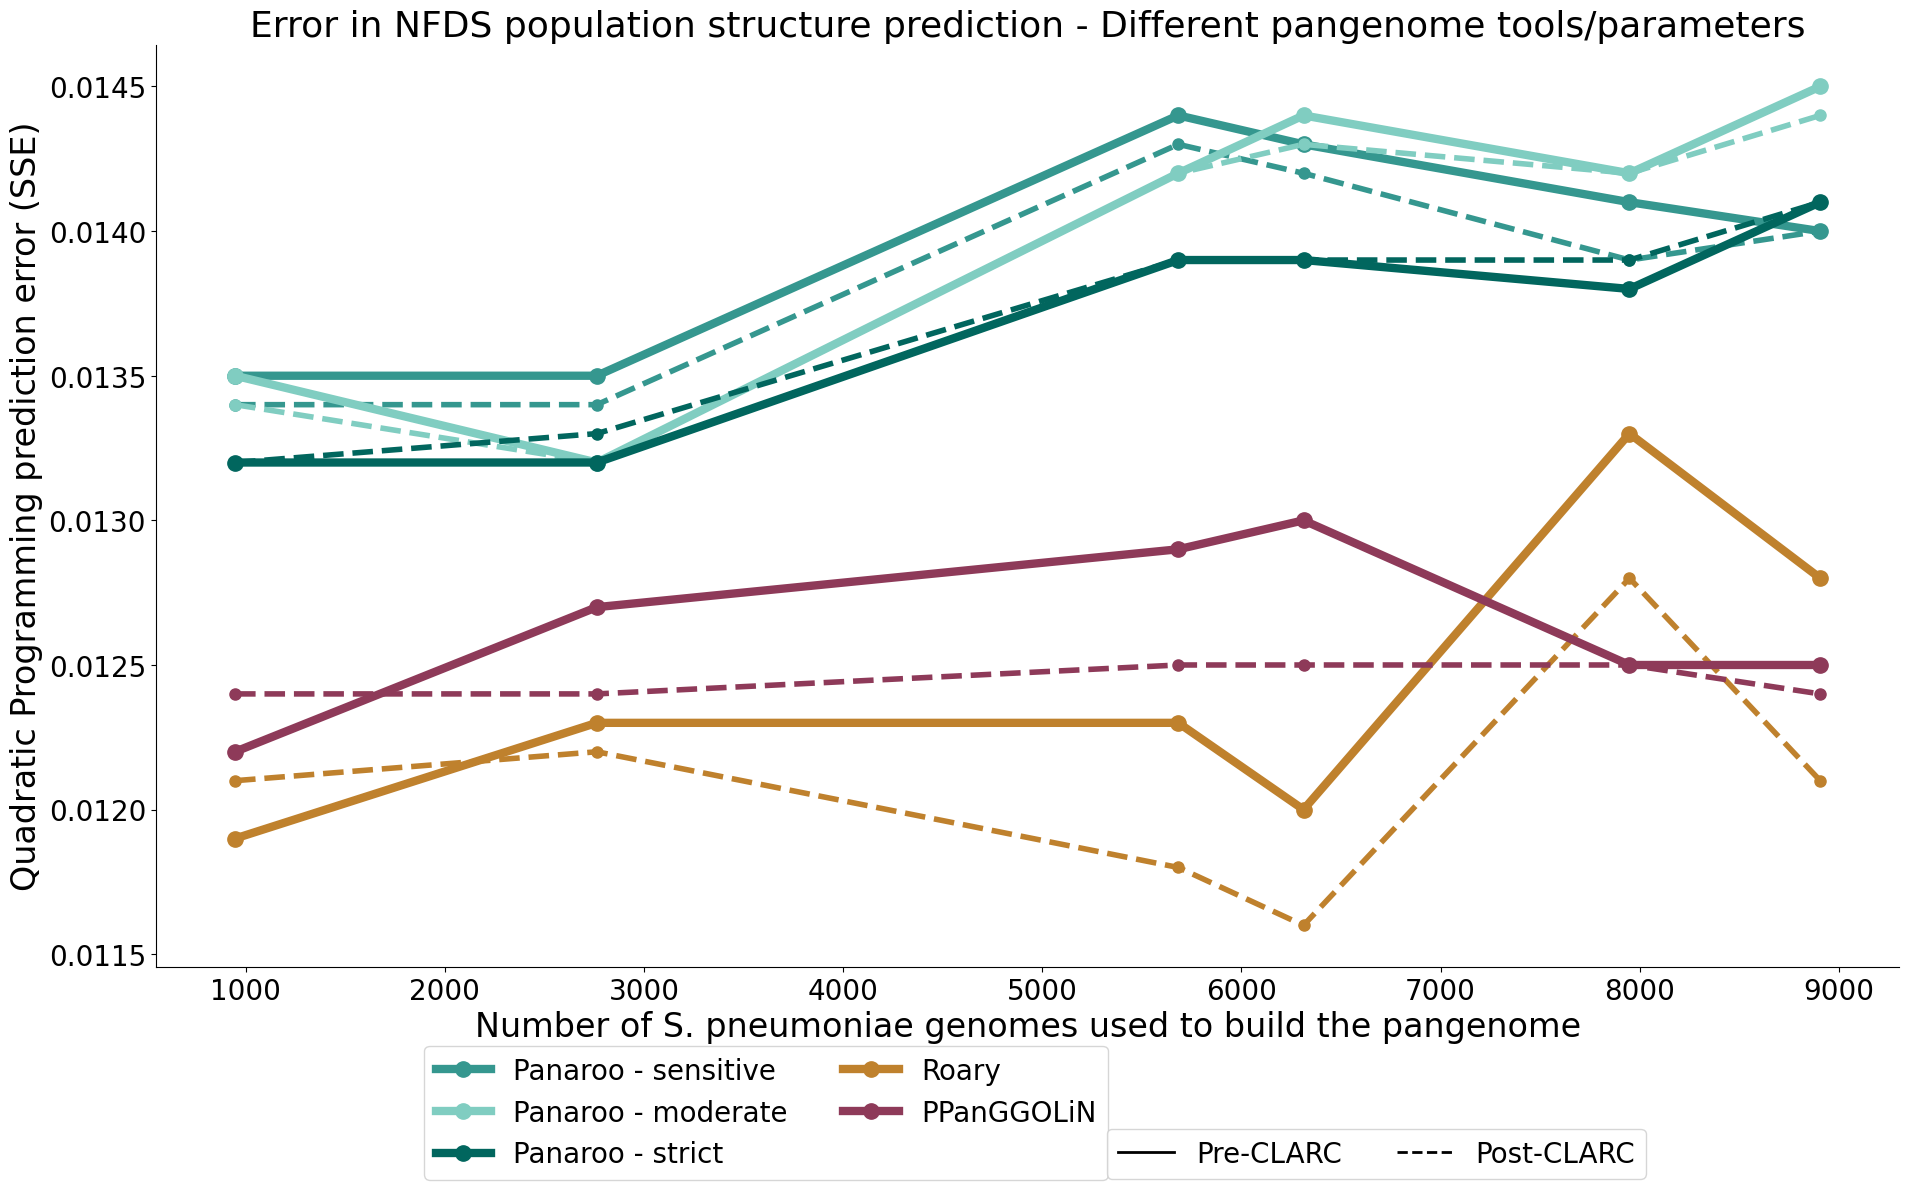

In [59]:
genome_num = [946, 2763, 5683, 6312, 7949, 8907]

tools_legend = [
    Line2D([0], [0], color='#35978f', lw=6, label='Panaroo - sensitive', marker='o', markersize=11),
    Line2D([0], [0], color='#80cdc1', lw=6, label='Panaroo - moderate', marker='o', markersize=11),
    Line2D([0], [0], color='#01665e', lw=6, label='Panaroo - strict', marker='o', markersize=11),
    Line2D([0], [0], color='#bf812d', lw=6, label='Roary', marker='o', markersize=11),
    Line2D([0], [0], color='#8E3A59', lw=6, label='PPanGGOLiN', marker='o', markersize=11)
]

clarc_legend = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Pre-CLARC'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Post-CLARC'),
]

plt.figure(figsize=(19, 12))  

plt.plot(genome_num, panaroo_i90_sensitive_qp_results_mass['panaroo_sw_qp_sse'], linestyle='-', color='#35978f', marker='o', markersize=11, linewidth=6, label='Panaroo - sensitive')
plt.plot(genome_num, panaroo_i90_sensitive_qp_results_mass['clarc_sw_qp_sse'], linestyle='--', color='#35978f', marker='o', markersize=8, linewidth=4)

plt.plot(genome_num, panaroo_i90_moderate_qp_results_mass['panaroo_sw_qp_sse'], linestyle='-', color='#80cdc1', marker='o', markersize=11, linewidth=6, label='Panaroo - moderate')
plt.plot(genome_num, panaroo_i90_moderate_qp_results_mass['clarc_sw_qp_sse'], linestyle='--', color='#80cdc1', marker='o', markersize=8, linewidth=4)

plt.plot(genome_num, panaroo_i90_strict_qp_results_mass['panaroo_sw_qp_sse'], linestyle='-', color='#01665e', marker='o', markersize=11, linewidth=6, label='Panaroo - strict (default)')
plt.plot(genome_num, panaroo_i90_strict_qp_results_mass['clarc_sw_qp_sse'], linestyle='--', color='#01665e', marker='o', markersize=8, linewidth=4)

plt.plot(genome_num, roary_i95_qp_results_mass['roary_sw_qp_sse'], linestyle='-', color='#bf812d', marker='o', markersize=11, linewidth=6, label='Roary')
plt.plot(genome_num, roary_i95_qp_results_mass['clarc_sw_qp_sse'], linestyle='--', color='#bf812d', marker='o', markersize=8, linewidth=4)

plt.plot(genome_num, ppanggo_i80_qp_results_mass['ppanggo_sw_qp_sse'], linestyle='-', color='#8E3A59', marker='o', markersize=11, linewidth=6, label='PPanGGOLiN')
plt.plot(genome_num, ppanggo_i80_qp_results_mass['clarc_sw_qp_sse'], linestyle='--', color='#8E3A59', marker='o', markersize=8, linewidth=4)

plt.xlabel('Number of S. pneumoniae genomes used to build the pangenome', fontsize=24)
plt.ylabel('Quadratic Programming prediction error (SSE)', fontsize=24)
plt.title('Error in NFDS population structure prediction - Different pangenome tools/parameters', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

first_legend = plt.legend(handles=tools_legend, fontsize=20, loc='upper center', bbox_to_anchor=(0.35, -0.07), ncol=2)
plt.gca().add_artist(first_legend)

plt.legend(handles=clarc_legend, fontsize=20, loc='upper center', bbox_to_anchor=(0.7, -0.16), ncol=2)

plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()